In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.scipy.special import gamma as jsp_gamma
from jax.scipy.special import gammaincc as jsp_gammaincc

from scipy.special import gamma as sp_gamma
from scipy.special import gammaincc as sp_gammaincc
from scipy.stats import gamma

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def c_gamma_biweight_prob_jax(x, a, b, sigma=3.0):
    s = 3.0 * sigma

    g_a = jsp_gamma(a)
    g_1pa = jsp_gamma(1+a)
    g_2pa = jsp_gamma(2+a)
    g_3pa = jsp_gamma(3+a)
    g_4pa = jsp_gamma(4+a)

    gincc_a = jsp_gammaincc(a, b*(s+x)) * g_a
    gincc_1pa = jsp_gammaincc(1+a, b*(s+x))*g_1pa
    gincc_2pa = jsp_gammaincc(2+a, b*(s+x))*g_2pa
    gincc_3pa = jsp_gammaincc(3+a, b*(s+x))*g_3pa
    gincc_4pa = jsp_gammaincc(4+a, b*(s+x))*g_4pa

    gincc_a_m = jsp_gammaincc(a, b*(x-s)) * g_a
    gincc_1pa_m = jsp_gammaincc(1+a, b*(x-s))*g_1pa
    gincc_2pa_m = jsp_gammaincc(2+a, b*(x-s))*g_2pa
    gincc_3pa_m = jsp_gammaincc(3+a, b*(x-s))*g_3pa
    gincc_4pa_m = jsp_gammaincc(4+a, b*(x-s))*g_4pa

    fbx = 4*b*x
    t0 = b**4 * (s**4 - 2*s**2*x**2 + x**4)
    t1 = 4*b**3 * (s**2*x - x**3)
    t2 = b**2 * (6*x**2 - 2*s**2)

    # branch 0 (-s < t < +s)
    tsum0 = (
                (g_a - gincc_a) * t0
                + (g_1pa - gincc_1pa) * t1
                + (g_2pa - gincc_2pa) * t2
                + g_4pa - gincc_4pa
                + gincc_3pa * fbx
                - g_2pa * (2*fbx + a*fbx)
    )

    # branch 1 ( t >= +s)
    tsum1 = (
                (gincc_a_m - gincc_a) * t0
                + (gincc_1pa_m - gincc_1pa) * t1
                + (gincc_2pa_m - gincc_2pa) * t2
                + (gincc_3pa - gincc_3pa_m) * fbx
                + gincc_4pa_m - gincc_4pa
    )

    # combine branches
    #tsum = jnp.where(x < s, tsum0, tsum1)
    tsum0 = jnp.where(x < s, tsum0, 0.0)
    tsum1 = jnp.where(x >= s, tsum1, 0.0)
    tsum = tsum0 + tsum1

    pre_fac = 15.0/(16*b**4*s**5*g_a)
    return pre_fac * tsum

In [3]:
def c_gamma_biweight_prob_scipy(x, a, b, sigma=3.0):
    s = 3.0 * sigma

    g_a = sp_gamma(a)
    g_1pa = sp_gamma(1+a)
    g_2pa = sp_gamma(2+a)
    g_3pa = sp_gamma(3+a)
    g_4pa = sp_gamma(4+a)

    gincc_a = sp_gammaincc(a, b*(s+x)) * g_a
    gincc_1pa = sp_gammaincc(1+a, b*(s+x))*g_1pa
    gincc_2pa = sp_gammaincc(2+a, b*(s+x))*g_2pa
    gincc_3pa = sp_gammaincc(3+a, b*(s+x))*g_3pa
    gincc_4pa = sp_gammaincc(4+a, b*(s+x))*g_4pa

    gincc_a_m = sp_gammaincc(a, b*(x-s)) * g_a
    gincc_1pa_m = sp_gammaincc(1+a, b*(x-s))*g_1pa
    gincc_2pa_m = sp_gammaincc(2+a, b*(x-s))*g_2pa
    gincc_3pa_m = sp_gammaincc(3+a, b*(x-s))*g_3pa
    gincc_4pa_m = sp_gammaincc(4+a, b*(x-s))*g_4pa

    fbx = 4*b*x
    t0 = b**4 * (s**4 - 2*s**2*x**2 + x**4)
    t1 = 4*b**3 * (s**2*x - x**3)
    t2 = b**2 * (6*x**2 - 2*s**2)

    # branch 0 (-s < t < +s)
    tsum0 = (
                (g_a - gincc_a) * t0
                + (g_1pa - gincc_1pa) * t1
                + (g_2pa - gincc_2pa) * t2
                + g_4pa - gincc_4pa
                + gincc_3pa * fbx
                - g_2pa * (2*fbx + a*fbx)
    )

    # branch 1 ( t >= +s)
    tsum1 = (
                (gincc_a_m - gincc_a) * t0
                + (gincc_1pa_m - gincc_1pa) * t1
                + (gincc_2pa_m - gincc_2pa) * t2
                + (gincc_3pa - gincc_3pa_m) * fbx
                + gincc_4pa_m - gincc_4pa
    )

    # combine branches
    tsum = np.where(x < s, tsum0, tsum1)

    pre_fac = 15.0/(16*b**4*s**5*g_a)
    return pre_fac * tsum

In [4]:
def gamma_pdf(x, a, b):
    y = gamma.pdf(x, a, scale=1/b)
    y = np.where(x <= 0, 0.0, y)
    return y

In [5]:
a = 1.001
b = 0.002
sigma = 3.0

xvals = np.linspace(-3*sigma, 200, 10000)

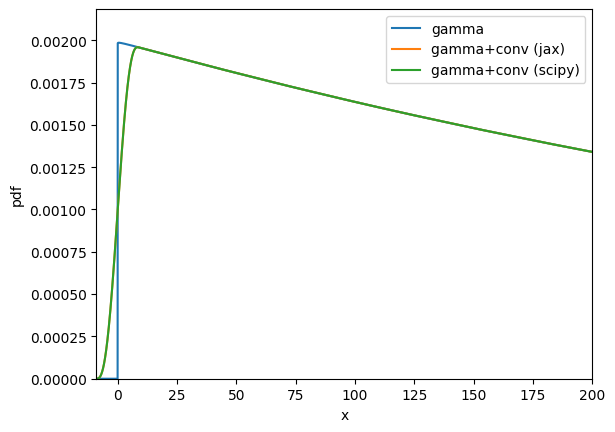

In [6]:
plt.figure()

yg = gamma_pdf(xvals, a, b)
yg_jax = c_gamma_biweight_prob_jax(xvals, a, b, sigma)
yg_scipy = c_gamma_biweight_prob_scipy(xvals, a, b, sigma)

plt.plot(xvals, yg, label='gamma')
plt.plot(xvals, yg_jax, label='gamma+conv (jax)')
plt.plot(xvals, yg_scipy, label='gamma+conv (scipy)')
plt.xlabel('x')
plt.ylabel('pdf')
plt.xlim([-9.0, 200.0])
plt.ylim([0.0, 1.1 * np.amax([yg, yg_jax, yg_scipy])])
plt.legend()
plt.show()

In [7]:
gamma_biweight_grad = jax.grad(c_gamma_biweight_prob_jax, argnums=(1, 2))

In [8]:
grads = gamma_biweight_grad(8.9, a, b, sigma)

In [9]:
print(grads)

(Array(nan, dtype=float64, weak_type=True), Array(nan, dtype=float64, weak_type=True))


In [10]:
def branch0(x, a, b, sigma):
    s = 3.0 * sigma

    g_a = jsp_gamma(a)
    g_1pa = jsp_gamma(1+a)
    g_2pa = jsp_gamma(2+a)
    g_3pa = jsp_gamma(3+a)
    g_4pa = jsp_gamma(4+a)

    gincc_a = jsp_gammaincc(a, b*(s+x)) * g_a
    gincc_1pa = jsp_gammaincc(1+a, b*(s+x))*g_1pa
    gincc_2pa = jsp_gammaincc(2+a, b*(s+x))*g_2pa
    gincc_3pa = jsp_gammaincc(3+a, b*(s+x))*g_3pa
    gincc_4pa = jsp_gammaincc(4+a, b*(s+x))*g_4pa

    gincc_a_m = jsp_gammaincc(a, b*(x-s)) * g_a
    gincc_1pa_m = jsp_gammaincc(1+a, b*(x-s))*g_1pa
    gincc_2pa_m = jsp_gammaincc(2+a, b*(x-s))*g_2pa
    gincc_3pa_m = jsp_gammaincc(3+a, b*(x-s))*g_3pa
    gincc_4pa_m = jsp_gammaincc(4+a, b*(x-s))*g_4pa

    fbx = 4*b*x
    t0 = b**4 * (s**4 - 2*s**2*x**2 + x**4)
    t1 = 4*b**3 * (s**2*x - x**3)
    t2 = b**2 * (6*x**2 - 2*s**2)

    # branch 0 (-s < t < +s)
    tsum0 = (
                (g_a - gincc_a) * t0
                + (g_1pa - gincc_1pa) * t1
                + (g_2pa - gincc_2pa) * t2
                + g_4pa - gincc_4pa
                + gincc_3pa * fbx
                - g_2pa * (2*fbx + a*fbx)
    )

    pre_fac = 15.0/(16*b**4*s**5*g_a)
    return pre_fac * tsum0

In [11]:
def branch1(x, a, b, sigma):
    s = 3.0 * sigma

    g_a = jsp_gamma(a)
    g_1pa = jsp_gamma(1+a)
    g_2pa = jsp_gamma(2+a)
    g_3pa = jsp_gamma(3+a)
    g_4pa = jsp_gamma(4+a)

    gincc_a = jsp_gammaincc(a, b*(s+x)) * g_a
    gincc_1pa = jsp_gammaincc(1+a, b*(s+x))*g_1pa
    gincc_2pa = jsp_gammaincc(2+a, b*(s+x))*g_2pa
    gincc_3pa = jsp_gammaincc(3+a, b*(s+x))*g_3pa
    gincc_4pa = jsp_gammaincc(4+a, b*(s+x))*g_4pa

    gincc_a_m = jsp_gammaincc(a, b*(x-s)) * g_a
    gincc_1pa_m = jsp_gammaincc(1+a, b*(x-s))*g_1pa
    gincc_2pa_m = jsp_gammaincc(2+a, b*(x-s))*g_2pa
    gincc_3pa_m = jsp_gammaincc(3+a, b*(x-s))*g_3pa
    gincc_4pa_m = jsp_gammaincc(4+a, b*(x-s))*g_4pa

    fbx = 4*b*x
    t0 = b**4 * (s**4 - 2*s**2*x**2 + x**4)
    t1 = 4*b**3 * (s**2*x - x**3)
    t2 = b**2 * (6*x**2 - 2*s**2)

    # branch 1 (-s < t < +s)
    tsum1 = (
                (gincc_a_m - gincc_a) * t0
                + (gincc_1pa_m - gincc_1pa) * t1
                + (gincc_2pa_m - gincc_2pa) * t2
                + (gincc_3pa - gincc_3pa_m) * fbx
                + gincc_4pa_m - gincc_4pa
    )

    pre_fac = 15.0/(16*b**4*s**5*g_a)
    return pre_fac * tsum1

In [12]:
branch0_grad = jax.grad(branch0, argnums=(1, 2))
branch1_grad = jax.grad(branch1, argnums=(1, 2))

In [13]:
grads = branch0_grad(9.0, a, b, sigma)

In [14]:
grads

(Array(-0.00691913, dtype=float64, weak_type=True),
 Array(0.96212272, dtype=float64, weak_type=True))

In [15]:
grads = branch1_grad(9.0, a, b, sigma)

In [16]:
grads

(Array(-0.00691913, dtype=float64, weak_type=True),
 Array(0.96212684, dtype=float64, weak_type=True))